In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy, math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from jacobi import propagate

In [4]:
from scipy.optimize import curve_fit
from matplotlib.ticker import ScalarFormatter

In [5]:
import gepard as g
print(g.__version__)

0.9.10


In [6]:
print(g.__file__)

/home/quantum/gepard/src/gepard/__init__.py


In [7]:
#import graphs

In [8]:
# graphs.setup_rc_params(presentation=True)
#graphs.setup_rc_params(publish=True)

In [9]:
#DRAFT = False
#FIGDIR = '/home/kkumer/papers/nloimpact/figs'
FIGDIR = '/home/quantum/Documents/gepard_gpd/figures_paper_published'

In [10]:
# belle2 default colormap  (color-blind safe)
bel_cmap = {'bel_blue': '#348ABD', 'bel_red': '#E24A33', 'bel_purple': '#988ED5',
            'bel_gray': '#777777', 'bel_yellow': '#FBC15E', 'bel_green': '#8EBA42',
            'bel_pink': '#FFB5B8'}

# Dataset

## $R = \sigma_L/\sigma_T$ function

We use $R$ ratio function, as developed and defined in `LT_separation.ipynb` and apply it to total $\sigma$ data, to get $\sigma_L$

In [11]:
def modelW_rho(W_Q2, pars):
    W, Q2 = W_Q2
    a, p, b = pars
    x = Q2/0.776**2
    y = Q2/W
    return x/(1+a*x)**p * (1-b*y)

def modelW_phi(W_Q2, pars):
    W, Q2 = W_Q2
    a, p = pars
    x = Q2/1.02**2
    return x/(1+a*x)**p

In [12]:
def RfunW(W, Q2, meson, collaboration='HERA'):
    '''Full Q^2 and W dependent R function.'''
    if meson == 'rho0':
        if collaboration == 'H1':
            # result of fit only to H1 measurements of R
            pars = np.array([3.4448593857655423, 1.0315014846337964, -82.29513762415807])
            cov = np.array([[856.4712332392247, -0.9533742942064789, -21835.31906014519],
                            [-0.9533742942064789, 0.33578280444411535, -105.20123774072994],
                            [-21835.31906014519, -105.20123774072994, 606922.8387879718]])
        elif collaboration == 'ZEUS':
            # result of fit only to ZEUS measurements of R
            pars = np.array([2.116938695130227, 0.43660161212399284, 0.3403615255395319])
            cov = np.array([[17.157623711807915, -1.055154593720807, 3.06553393461163],
                            [-1.055154593720807, 0.06616338741413422, -0.21515323325912508],
                            [3.06553393461163, -0.21515323325912508, 1.1921747441948811]])
        else:  # HERA
            # Result of fit to combined H1 and ZEUS measurements of R
            pars = np.array([6.251397432195975, 0.3211706244931314, 0.9022081518021978])
            cov = np.array([[372.9802979798167, -4.341668334106043, 9.752091026822168],
                            [-4.341668334106043, 0.051452436510795736, -0.13166750799083524],
                            [9.752091026822168, -0.13166750799083524, 0.7102237117713996]])
        y, ycov = propagate(lambda p: modelW_rho((W, Q2), p), pars, cov)
    elif meson == 'phi':
        # Result of fit to combined H1 and ZEUS R (not so reliable, not used anyways)
        pars = np.array([5.794868768486252, 0.26720102753302516])
        cov = np.array([[774.2660285968365, -9.163763185567973],
                        [-9.163763185567973, 0.10930118470470186]])
        y, ycov = propagate(lambda p: modelW_phi((W, Q2), p), pars, cov)
        
    else:
        raise ValueError('Not implemented for {}'.format(meson))
    try:
        yerr_prop = np.diag(ycov) ** 0.5
    except ValueError:  # not an array
        yerr_prop = ycov ** 0.5
    return y, yerr_prop

In [13]:
def sigtot2sigL(dtset, collaboration='HERA'):
    '''Transform total xs dataset to longitudinal xs dataset.'''
    out = []
    for pt in g.select(dtset, criteria=['Q2 >= 4.0']):
        ptxl = pt.copy()
        y = (pt.W**2 + pt.Q2 - g.constants.Mp2)/(pt.s - g.constants.Mp2)
        eps = (1-y)/(1-y+y**2/2)
        R, delR = RfunW(ptxl.W, pt.Q2, ptxl.out1particle, collaboration)
        ptxl.val = pt.val/(eps + 1./R)
        errsig = pt.err / (eps+1./R)
        errR = pt.val * delR / (1.+eps*R)**2
        ptxl.err = np.sqrt( errsig**2 + errR**2)
        ptxl.in1polarization = '1'
        ptxl.in1polarizationvector = 'L'
        ptxl.y1namelong = 'differential cross section XL'
        out.append(ptxl)
    return g.DataSet(out)

# H1 DVMP Data

In [14]:
# Q^2 dependent data for fixed W
H1_rho_Q2 = sigtot2sigL(g.dset[606], collaboration='H1')
H1_phi_Q2 = sigtot2sigL(g.dset[77])

In [15]:
# W-dependent data for several Q^2 values
H1_rho_W = sigtot2sigL(g.dset[79], collaboration='H1')
H1_phi_W = sigtot2sigL(g.dset[80])

In [16]:
# t-dependent data (problematic to use!)
H1_rho_t = sigtot2sigL(g.dset[75], collaboration='H1')

# ZEUS DVMP Data 

In [17]:
# Q^2 dependent data for fixed W
ZEUS_rho_Q2 = sigtot2sigL(g.dset[607], collaboration='ZEUS')
ZEUS_phi_Q2 = sigtot2sigL(g.dset[612])

In [18]:
# W-dependent data for several Q^2 values
ZEUS_rho_W = sigtot2sigL(g.dset[608], collaboration='ZEUS')
# ZEUS_phi_W = sigtot2sigL(g.dset[613])

We fit only to DVMP data with $Q^2$ > 10 GeV$^2$ where we expect pQCD to work reasonably for this process.

In [19]:
DVMP_Q2_points = g.select(H1_rho_Q2 +
                          ZEUS_rho_Q2, ['Q2 >= 10.0'])
DVMP_W_points = g.select(H1_rho_W +
                          ZEUS_rho_W, ['Q2 >= 10.0'])
DVMP_t_points = g.select(H1_rho_t, ['Q2 >= 10.0'])
DVMPpoints = DVMP_Q2_points + DVMP_W_points
print("Number of DVMP points = {}".format(len(DVMPpoints)))

Number of DVMP points = 45


# Theory 

In [20]:
class MyTheory(g.PWNormGPD, g.MellinBarnesCFF, g.MellinBarnesTFF, g.DVMP):
    pass

In [21]:
th1 = MyTheory(p=0)
th1.__name__ = 'th1'
th1.name = 'LO DVCS+DVMP'
#th1.parameters.update(pars_init)
th1.parameters.update({'a2':0.132, 'ns': 0.15203977400125948, 'al0s': 1.1575112053844445, 'al0g': 1.2473462505438417, 'alps': 0.46088402725599625, 'ms2': 1.8846575048660557, 'secs': 0.19141756012117567, 'this': -0.09985644463925375, 'alpg': 0.9994253236092058, 'mg2': 0.12655660165151106, 'secg': 0.9348434846666352, 'thig': -0.8070230139684945})
#th1.parameters.update({'a2': 0.123, 'ns': 0.15203977400126656, 'al0s': 1.1575112053849788, 'al0g': 1.2473462505404416, 'alps': 0.5312673554988383, 'ms2': 2.740237296159404, 'secs': 0.04939583198250308, 'this': -0.05411781123920072, 'alpg': 0.9999999988492917, 'mg2': 0.11935246209863909, 'secg': 1.342447132772215, 'thig': -0.9997960402412689})
#th1.fitpoints = DVCSpoints+DVMPpoints
th1.props = {'lw': 1.5, 'color': bel_cmap['bel_red'], 'ls': '-'}

In [22]:
th0 = MyTheory(p=0)
th0.__name__ = 'th0'
th0.name = 'LO DVMP'
th0.parameters.update({'a2':0.132, 'ns': 0.15203977400125948, 'al0s': 1.1575112053844445, 'al0g': 1.2473462505438417, 'alps': 0.12307549922319476, 'ms2': 0.9099618573067466, 'secs': 0.29987036520060867, 'this': 0.09993798993395209, 'alpg': 0.803523260238303, 'mg2': 0.14348108904312137, 'secg': -0.4916482158284232, 'thig': -0.4345237152334432})
th0.fitpoints = DVMPpoints
th0.props = {'lw': 1.5, 'color': bel_cmap['bel_green'], 'ls': '-.'}

In [23]:
th1_asy_DA = MyTheory(p=0)
th1_asy_DA.__name__ = 'th1_asy_DA'
th1_asy_DA.name = 'LO DVCS+DVMP (Asymptotic DA)'
#th1.parameters.update(pars_init)
th1_asy_DA.parameters.update({'a2':0.0, 'ns': 0.15203977400125948, 'al0s': 1.1575112053844445, 'al0g': 1.2473462505438417, 'alps': 0.46088402725599625, 'ms2': 1.8846575048660557, 'secs': 0.19141756012117567, 'this': -0.09985644463925375, 'alpg': 0.9994253236092058, 'mg2': 0.12655660165151106, 'secg': 0.9348434846666352, 'thig': -0.8070230139684945})
#th1.parameters.update({'a2': 0.123, 'ns': 0.15203977400126656, 'al0s': 1.1575112053849788, 'al0g': 1.2473462505404416, 'alps': 0.5312673554988383, 'ms2': 2.740237296159404, 'secs': 0.04939583198250308, 'this': -0.05411781123920072, 'alpg': 0.9999999988492917, 'mg2': 0.11935246209863909, 'secg': 1.342447132772215, 'thig': -0.9997960402412689})
#th1.fitpoints = DVCSpoints+DVMPpoints
th1_asy_DA.props = {'lw': 1, 'color': bel_cmap['bel_gray'], 'ls': '-'}

In [24]:
th0_asy_DA = MyTheory(p=0)
th0_asy_DA.__name__ = 'th0_asy_DA'
th0_asy_DA.name = 'LO DVMP (Asymptotic DA)'
th0_asy_DA.parameters.update({'a2':0.0, 'ns': 0.15203977400125948, 'al0s': 1.1575112053844445, 'al0g': 1.2473462505438417, 'alps': 0.12307549922319476, 'ms2': 0.9099618573067466, 'secs': 0.29987036520060867, 'this': 0.09993798993395209, 'alpg': 0.803523260238303, 'mg2': 0.14348108904312137, 'secg': -0.4916482158284232, 'thig': -0.4345237152334432})
th0_asy_DA.fitpoints = DVMPpoints
th0_asy_DA.props = {'lw': 1, 'color': bel_cmap['bel_blue'], 'ls': '-.'}

# Ploting: Theory and Data 

In [25]:
def line_label(dtset, extended=False):
    """Return location and label for dataset plotting."""
    pt = dtset[-1]  # last point
    y = pt.val
    d = pt.W - dtset[-2].W  # distance between last two points
    x = pt.W + d/5
    if extended:
        return x, y, r'$\mathcal{{Q}}^2 = {}\:\mathrm{{GeV}}^2$'.format(pt.Q2)
    else:
        return x, y, r'${}\:\mathrm{{GeV}}^2$'.format(pt.Q2)
    # return x, y, '{}'.format(pt.Q2)

## $Q^2$ scaling - fixed W

In [26]:
#Q2points = g.select(H1_rho_Q2, ['Q2 >= 10.0'])

In [27]:
#logQ2 = np.log10(Q2points.df().Q2.values)
#logSigL = np.log10(Q2points.df().val.values)

In [28]:
#logerr = Q2points.df().err.values / Q2points.df().val.values / np.log(10)

In [29]:
#logpred1 = np.array([np.log10(thm1.predict(pt)) for pt in Q2points])
#logpred0 = np.array([np.log10(th0.predict(pt)) for pt in Q2points])

In [30]:
def DVMP_scaling(ths, draft=False):                                                                       
    fig, ax1 = plt.subplots(1, 1, figsize=[7.5, 5])                                                                     
    #fac = (np.sqrt(2)*g.constants.F_phi/g.constants.F_rho0/3)**2                                                      
    rho_vals = H1_rho_Q2.df().Q2.values**(2.5)*H1_rho_Q2.df().val.values                                              
    rho_errs = H1_rho_Q2.df().Q2.values**(2.5)*H1_rho_Q2.df().err.values                                              
    ax1.errorbar(H1_rho_Q2.df().Q2.values, rho_vals, yerr=rho_errs,                                                   
                marker='o', color='black', linestyle='None', label=r'$\rho^0$')                                                      
    for TH in ths:                                                                                                    
        dtset_rho = g.select(H1_rho_Q2, ['Q2 >= 10.'])                                                                
        rho_preds = [TH.predict(pt) for pt in dtset_rho]                                                              
        rho_preds = dtset_rho.df().Q2.values**(2.5)*np.array(rho_preds)                                               
        ax1.plot(dtset_rho.df().Q2.values, rho_preds, label=TH.name, **TH.props)                                      
    #dtset_phi = H1_phi_Q2                                                                                             
    #phi_vals = dtset_phi.df().Q2.values**(2.5)*dtset_phi.df().val.values/fac                                          
    #phi_errs = dtset_phi.df().Q2.values**(2.5)*dtset_phi.df().err.values/fac                                          
    #ax1.errorbar(dtset_phi.df().Q2.values, phi_vals, yerr=phi_errs, marker='v', linestyle='None',
    #             color=bel_cmap['bel_blue'],
    #             label=r'$\phi\times (3 f_{\rho^0}/\sqrt{2} f_{\phi})^2$')          ## $Q^2$ scaling - fixed W                           
    ax1.set_yscale('log')                                                                                             
    ax1.set_xlabel(r'$\mathcal{Q}^{2}\;[\mathrm{GeV}^2]$')                                                            
    #ax1.set_ylabel(r'$\mathcal{Q}^5\sigma(\gamma_{\rm L}^* \textup{p} \to \textup{V} \textup{p})\;[\mathrm{nb}]$')                                                                                        
    ax1.set_ylabel(r'$\mathcal{Q}^5\sigma(\gamma_{L}^* p \rightarrow V p)\;[\mathrm{nb}]$')                                                                                        
    ax1.set_ylim(1000, 20000)                                                                                         
    ax1.legend(loc='lower right', handlelength=3.5)
    ax1.set_title('$a_2=0.132, \mu = 2~GeV$')                                                                   
    return fig

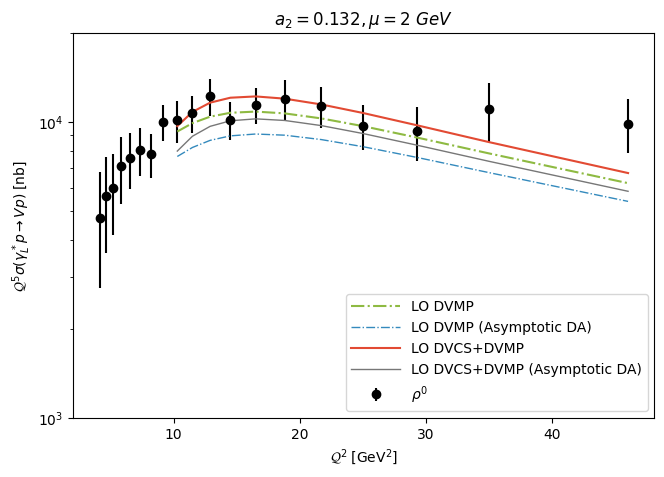

In [31]:
fig = DVMP_scaling([th0, th0_asy_DA, th1, th1_asy_DA ])

In [32]:
fig.savefig('{}/Q2_scaling_W_fix.pdf'.format(FIGDIR))